In [1]:
import warnings
warnings.filterwarnings("ignore")
import scanpy as sc
sc.settings.verbosity = 3  
sc.set_figure_params()

In [2]:
adata=sc.read("adata_all.h5ad")

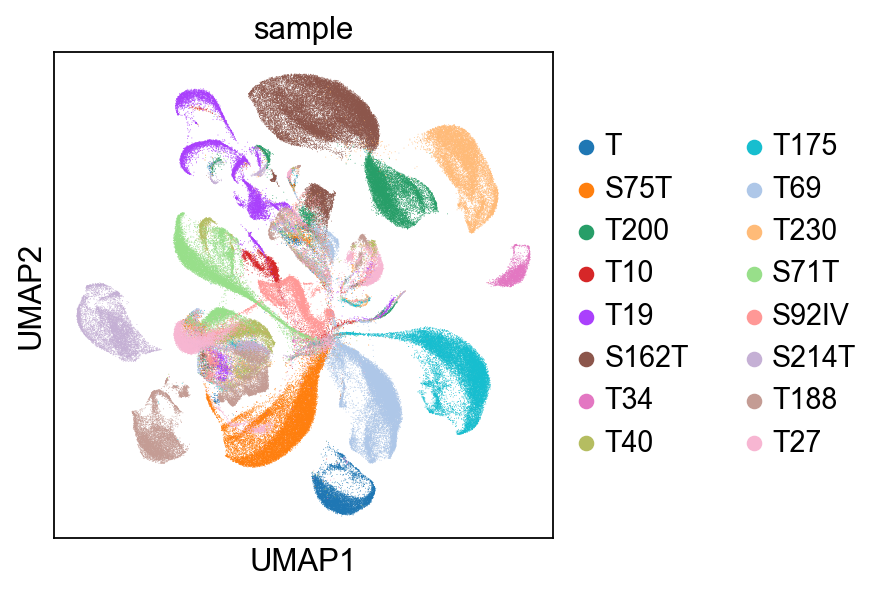

In [3]:
sc.pl.umap(adata,color="sample")

In [4]:
import pandas as pd
annot=pd.read_csv("GSE137804_Tumor_dataset_annotation.csv.gz")

In [5]:
annot=annot.loc[~annot["sample"].isin(["T214",'T174','T44','T188','T69',"T230","T200","T162"])]

In [6]:
annot["sample"].unique()

array(['T10', 'T19', 'T27', 'T34', 'T40', 'T71', 'T75', 'T92'],
      dtype=object)

In [7]:
anndict=dict(zip(["T10","T19","T27","T34","T40","S71T","S75T","S92IV"],annot["sample"].unique()))

In [8]:
anndict

{'T10': 'T10',
 'T19': 'T19',
 'T27': 'T27',
 'T34': 'T34',
 'T40': 'T40',
 'S71T': 'T71',
 'S75T': 'T75',
 'S92IV': 'T92'}

In [9]:
adata=adata[~adata.obs["sample"].isin(["S214T","T","T175","T188",'T69',"T230","T200","S162T"])]

In [10]:
adata.obs["sample"]=adata.obs["sample"].cat.rename_categories([anndict[s] for s in adata.obs["sample"].cat.categories])

Trying to set attribute `.obs` of view, copying.


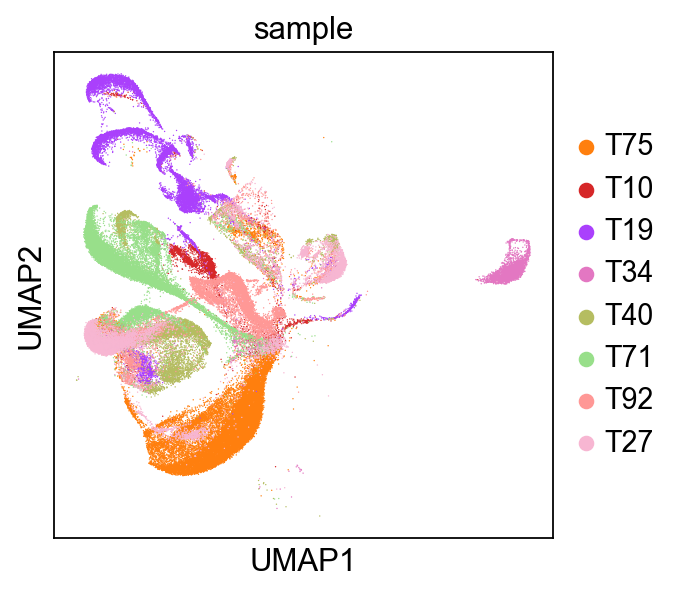

In [11]:
sc.pl.umap(adata,color="sample",cmap="Tableau 10")

In [15]:
sc.pp.filter_genes(adata,min_cells=3)

filtered out 2631 genes that are detected in less than 3 cells


In [16]:
import cupy as cp
import rapids_scanpy_funcs as rap
scaled = cp.array(adata[:,adata.var["highly_variable"]].X.todense(), order="F")
scaled = rap.scale(scaled, max_value=10)

In [17]:
from cuml import PCA
adata.obsm["X_pca"] = (PCA(n_components=50).fit_transform(scaled)).get()

In [18]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30,method="rapids")

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)


In [19]:
sc.tl.umap(adata,method="rapids")

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:00)


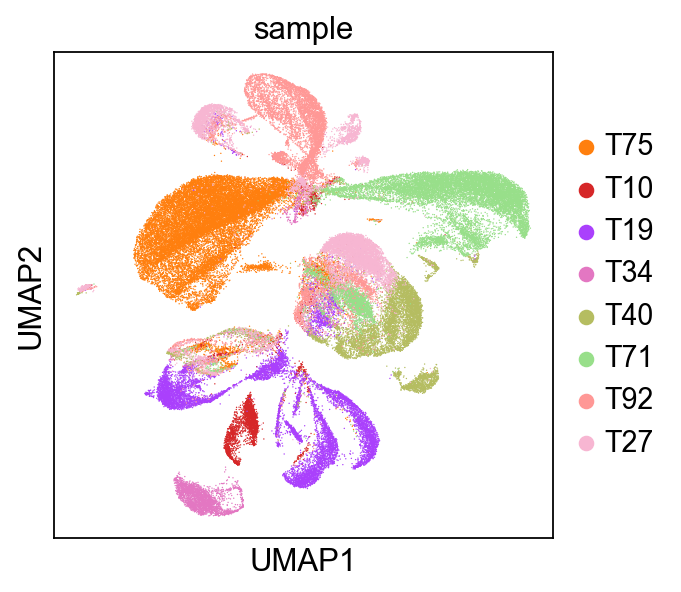

In [22]:
sc.set_figure_params(dpi_save=600)
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Arial']
sc.pl.umap(adata,color="sample",cmap="Tableau 10",save="NB_8patients.svg")

In [13]:
adata.obs["bc"]=list(map(lambda x: x.split("-")[0],adata.obs_names))

adata.obs["bc"]= adata.obs[['bc', 'sample']].apply(lambda x: '-'.join(x), axis=1)

import re
annot["bc"]=list(map(lambda c: re.sub('[^ATGC]', '', c),annot.cell_id))

annot["bc"]= annot[['bc', 'sample']].apply(lambda x: '-'.join(x), axis=1)
adata_raw=sc.read("adata_raw.h5ad")
adata_raw=adata_raw[adata.obs_names]


In [16]:
adata.obs_names = adata.obs.bc.values
adata_raw.obs_names = adata.obs.bc.values

In [18]:
annot=annot[annot.annotation.isin(['tumor', 'fibroblast', 'schwann_cell'])]

In [19]:
annot=annot.drop_duplicates("bc",keep=False)

In [20]:
adata_ss2 = sc.read('../../SS2/adata_tree_analyzed.h5ad')

In [21]:
pd.Series(adata_raw.var_names).to_csv("to_align/features.tsv",index=False,header=False)

In [42]:
import scipy.io
for s in annot["sample"].unique():
    bcs=annot[annot["sample"]==s].bc
    scipy.io.mmwrite("to_align/"+s+"_matrix.mtx",adata_raw[annot[annot["sample"]==s].bc].X.astype(int))
    pd.Series(bcs).to_csv("to_align/"+s+"_barcodes.tsv",index=False,header=False)
    

In [22]:
samples = annot["sample"].unique()

In [23]:
import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

In [24]:
adata_ss2.obs.milestones.to_csv("milestones.csv",header=False)

In [30]:
%%R -i samples
library(conos)
library(Matrix)
features = readLines("to_align/features.tsv")
load("../../SS2/p2_Sox10_mega.RData")
p2$calculatePcaReduction(nPcs=100,maxit=1000)

mls = read.csv("milestones.csv",header=FALSE,row.names=1)
milestones = mls$V2
names(milestones)=rownames(mls)

leiden = p2$clusters$PCA$leiden

for (s in samples){
    mtx=as(readMM(paste0("to_align/",s,"_matrix.mtx")), "dgCMatrix")
    barcodes = readLines(paste0("to_align/",s,"_barcodes.tsv"))
    rownames(mtx)=barcodes
    colnames(mtx)=stringr::str_to_title(features)
    p2_nb=pagoda2::basicP2proc(t(mtx),n.cores = 20,n.odgenes = NULL,get.largevis=FALSE,get.tsne = FALSE, make.geneknn=FALSE)

    panel<-list(p2,p2_nb)
    names(panel)<-c("ss2","nb")

    con <- Conos$new(panel, n.cores=1)
    con$buildGraph(k=15, k.self=5, space='PCA', ncomps=30)
    
    graph_conn = igraph::as_adjacency_matrix(con$graph, attr="weight")
    
    
    leiden_proj <- con$propagateLabels(labels = leiden, verbose=FALSE)
    milestones_proj <- con$propagateLabels(labels = milestones, verbose=FALSE)
    
    proj_names <- names(milestones_proj$labels)
    
    writeMM(graph_conn,paste0("to_align/",s,"_","con_graph.mtx"))
    writeLines(colnames(graph_conn),paste0("to_align/",s,"_","members.tsv"))
    writeLines(leiden_proj$labels,paste0("to_align/",s,"_","leiden_proj.tsv"))
    writeLines(milestones_proj$labels,paste0("to_align/",s,"_","milestones_proj.tsv"))
    writeLines(proj_names,paste0("to_align/",s,"_","proj_names.tsv"))
}


R[write to console]: Loading required package: Matrix

R[write to console]: Loading required package: igraph

R[write to console]: 
Attaching package: ‘igraph’


R[write to console]: The following objects are masked from ‘package:stats’:

    decompose, spectrum


R[write to console]: The following object is masked from ‘package:base’:

    union




running PCA using 5994 OD genes .... done


R[write to console]: 1914cells,31898genes; normalizing ... 

R[write to console]: using plain model 

R[write to console]: winsorizing ... 

R[write to console]: log scale ... 

R[write to console]: done.


R[write to console]: calculating variance fit ...

R[write to console]:  using gam 

R[write to console]: 182overdispersed genes ...182

R[write to console]: persisting ... 

R[write to console]: done.


R[write to console]: running PCA using 182 OD genes .

R[write to console]: .

R[write to console]: Warning in irlba(x, nv = nPcs, nu = 0, center = cm, right_only = FALSE,  :
R[write to console]: 
 
R[write to console]:  You're computing too large a percentage of total singular values, use a standard svd instead.

R[write to console]: .

R[write to console]: .

R[write to console]:  done




creating space of type angular done
adding data ... done
building index ... done
querying ... done


R[write to console]: found 0 out of 1 cached PCA space pairs ... 

R[write to console]: running 1 additional PCA space pairs 



.

R[write to console]:  done

R[write to console]: inter-sample links using mNN 



.

R[write to console]:  done

R[write to console]: local pairs 

R[write to console]: .

R[write to console]: .

R[write to console]:  done


R[write to console]: building graph .



.

R[write to console]: done

R[write to console]: 2209cells,31898genes; normalizing ... 

R[write to console]: using plain model 

R[write to console]: winsorizing ... 

R[write to console]: log scale ... 

R[write to console]: done.


R[write to console]: calculating variance fit ...

R[write to console]:  using gam 

R[write to console]: 452overdispersed genes ...452

R[write to console]: persisting ... 

R[write to console]: done.


R[write to console]: running PCA using 452 OD genes .

R[write to console]: .

R[write to console]: .

R[write to console]: .

R[write to console]:  done




creating space of type angular done
adding data ... done
building index ... done
querying ... done


R[write to console]: found 0 out of 1 cached PCA space pairs ... 

R[write to console]: running 1 additional PCA space pairs 



.

R[write to console]:  done

R[write to console]: inter-sample links using mNN 



.

R[write to console]:  done

R[write to console]: local pairs 

R[write to console]: .

R[write to console]: .

R[write to console]:  done


R[write to console]: building graph .



.

R[write to console]: done

R[write to console]: 753cells,31898genes; normalizing ... 

R[write to console]: using plain model 

R[write to console]: winsorizing ... 

R[write to console]: log scale ... 

R[write to console]: done.


R[write to console]: calculating variance fit ...

R[write to console]:  using gam 

R[write to console]: 103overdispersed genes ...103

R[write to console]: persisting ... 

R[write to console]: done.


R[write to console]: running PCA using 103 OD genes .

R[write to console]: .

R[write to console]: Warning in irlba(x, nv = nPcs, nu = 0, center = cm, right_only = FALSE,  :
R[write to console]: 
 
R[write to console]:  You're computing too large a percentage of total singular values, use a standard svd instead.

R[write to console]: .

R[write to console]: .

R[write to console]:  done




creating space of type angular done
adding data ... done
building index ... done
querying ... done


R[write to console]: found 0 out of 1 cached PCA space pairs ... 

R[write to console]: running 1 additional PCA space pairs 



.

R[write to console]:  done

R[write to console]: inter-sample links using mNN 



.

R[write to console]:  done

R[write to console]: local pairs 

R[write to console]: .

R[write to console]: .

R[write to console]:  done


R[write to console]: building graph .



.

R[write to console]: done

R[write to console]: 2440cells,31898genes; normalizing ... 

R[write to console]: using plain model 

R[write to console]: winsorizing ... 

R[write to console]: log scale ... 

R[write to console]: done.


R[write to console]: calculating variance fit ...

R[write to console]:  using gam 

R[write to console]: 300overdispersed genes ...300

R[write to console]: persisting ... 

R[write to console]: done.


R[write to console]: running PCA using 300 OD genes .

R[write to console]: .

R[write to console]: .

R[write to console]: .

R[write to console]:  done




creating space of type angular done
adding data ... done
building index ... done
querying ... done


R[write to console]: found 0 out of 1 cached PCA space pairs ... 

R[write to console]: running 1 additional PCA space pairs 



.

R[write to console]:  done

R[write to console]: inter-sample links using mNN 



.

R[write to console]:  done

R[write to console]: local pairs 

R[write to console]: .

R[write to console]: .

R[write to console]:  done


R[write to console]: building graph .



.

R[write to console]: done

R[write to console]: 975cells,31898genes; normalizing ... 

R[write to console]: using plain model 

R[write to console]: winsorizing ... 

R[write to console]: log scale ... 

R[write to console]: done.


R[write to console]: calculating variance fit ...

R[write to console]:  using gam 

R[write to console]: 304overdispersed genes ...304

R[write to console]: persisting ... 

R[write to console]: done.


R[write to console]: running PCA using 304 OD genes .

R[write to console]: .

R[write to console]: .

R[write to console]: .

R[write to console]:  done




creating space of type angular done
adding data ... done
building index ... done
querying ... done


R[write to console]: found 0 out of 1 cached PCA space pairs ... 

R[write to console]: running 1 additional PCA space pairs 



.

R[write to console]:  done

R[write to console]: inter-sample links using mNN 



.

R[write to console]:  done

R[write to console]: local pairs 

R[write to console]: .

R[write to console]: .

R[write to console]:  done


R[write to console]: building graph .



.

R[write to console]: done

R[write to console]: 9393cells,31898genes; normalizing ... 

R[write to console]: using plain model 

R[write to console]: winsorizing ... 

R[write to console]: log scale ... 

R[write to console]: done.


R[write to console]: calculating variance fit ...

R[write to console]:  using gam 

R[write to console]: 434overdispersed genes ...434

R[write to console]: persisting ... 

R[write to console]: done.


R[write to console]: running PCA using 434 OD genes .

R[write to console]: .

R[write to console]: .

R[write to console]: .

R[write to console]:  done




creating space of type angular done
adding data ... done
building index ... done
querying ... done


R[write to console]: found 0 out of 1 cached PCA space pairs ... 

R[write to console]: running 1 additional PCA space pairs 



.

R[write to console]:  done

R[write to console]: inter-sample links using mNN 



.

R[write to console]:  done

R[write to console]: local pairs 

R[write to console]: .

R[write to console]: .

R[write to console]:  done


R[write to console]: building graph .



.

R[write to console]: done

R[write to console]: 15075cells,31898genes; normalizing ... 

R[write to console]: using plain model 

R[write to console]: winsorizing ... 

R[write to console]: log scale ... 

R[write to console]: done.


R[write to console]: calculating variance fit ...

R[write to console]:  using gam 

R[write to console]: 304overdispersed genes ...304

R[write to console]: persisting ... 

R[write to console]: done.


R[write to console]: running PCA using 304 OD genes .

R[write to console]: .

R[write to console]: .

R[write to console]: .

R[write to console]:  done




creating space of type angular done
adding data ... done
building index ... done
querying ... done


R[write to console]: found 0 out of 1 cached PCA space pairs ... 

R[write to console]: running 1 additional PCA space pairs 



.

R[write to console]:  done

R[write to console]: inter-sample links using mNN 



.

R[write to console]:  done

R[write to console]: local pairs 

R[write to console]: .

R[write to console]: .

R[write to console]:  done


R[write to console]: building graph .



.

R[write to console]: done

R[write to console]: 2732cells,31898genes; normalizing ... 

R[write to console]: using plain model 

R[write to console]: winsorizing ... 

R[write to console]: log scale ... 

R[write to console]: done.


R[write to console]: calculating variance fit ...

R[write to console]:  using gam 

R[write to console]: 299overdispersed genes ...299

R[write to console]: persisting ... 

R[write to console]: done.


R[write to console]: running PCA using 299 OD genes .

R[write to console]: .

R[write to console]: .

R[write to console]: .

R[write to console]:  done




creating space of type angular done
adding data ... done
building index ... done
querying ... done


R[write to console]: found 0 out of 1 cached PCA space pairs ... 

R[write to console]: running 1 additional PCA space pairs 



.

R[write to console]:  done

R[write to console]: inter-sample links using mNN 



.

R[write to console]:  done

R[write to console]: local pairs 

R[write to console]: .

R[write to console]: .

R[write to console]:  done


R[write to console]: building graph .



.

R[write to console]: done



In [25]:
annot.set_index("bc",inplace=True)

In [28]:
from scipy.sparse import csr_matrix
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import scvelo as scv


In [42]:
dct_smp=dict(zip(anndict.values(),anndict.keys()))

Trying to set attribute `.obs` of view, copying.


filtered out 10768 genes that are detected in less than 1 cells


Trying to set attribute `.var` of view, copying.


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


... storing 'annotations' as categorical
... storing 'milestones_proj' as categorical


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)
Filtered out 32632 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Exctracted 2000 highly variable genes.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics
    finished (0:00:51) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished

Trying to set attribute `.obs` of view, copying.


filtered out 11131 genes that are detected in less than 1 cells


Trying to set attribute `.var` of view, copying.


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


... storing 'annotations' as categorical
... storing 'milestones_proj' as categorical


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)
Filtered out 33364 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Exctracted 2000 highly variable genes.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics
    finished (0:00:34) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished

Trying to set attribute `.obs` of view, copying.


filtered out 9578 genes that are detected in less than 1 cells


Trying to set attribute `.var` of view, copying.


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


... storing 'annotations' as categorical
... storing 'milestones_proj' as categorical


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)
Filtered out 30966 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Exctracted 2000 highly variable genes.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics
    finished (0:01:12) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 0 region of root cells and 1 region of end points .
    finished

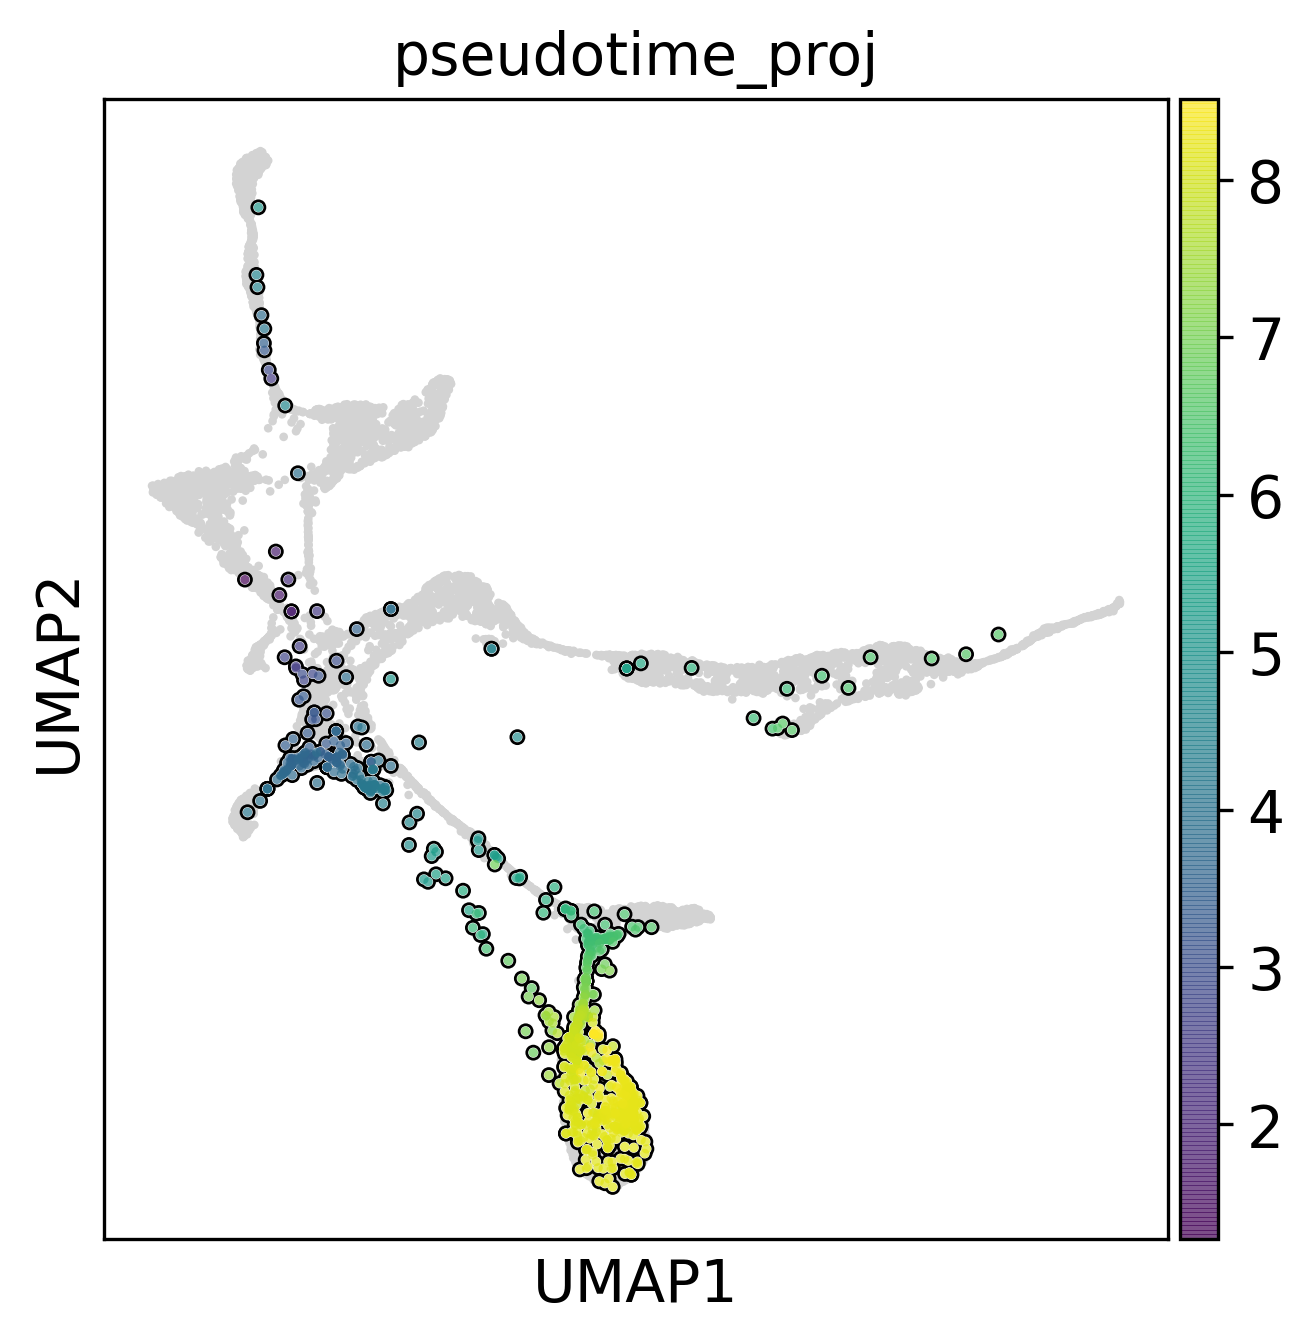

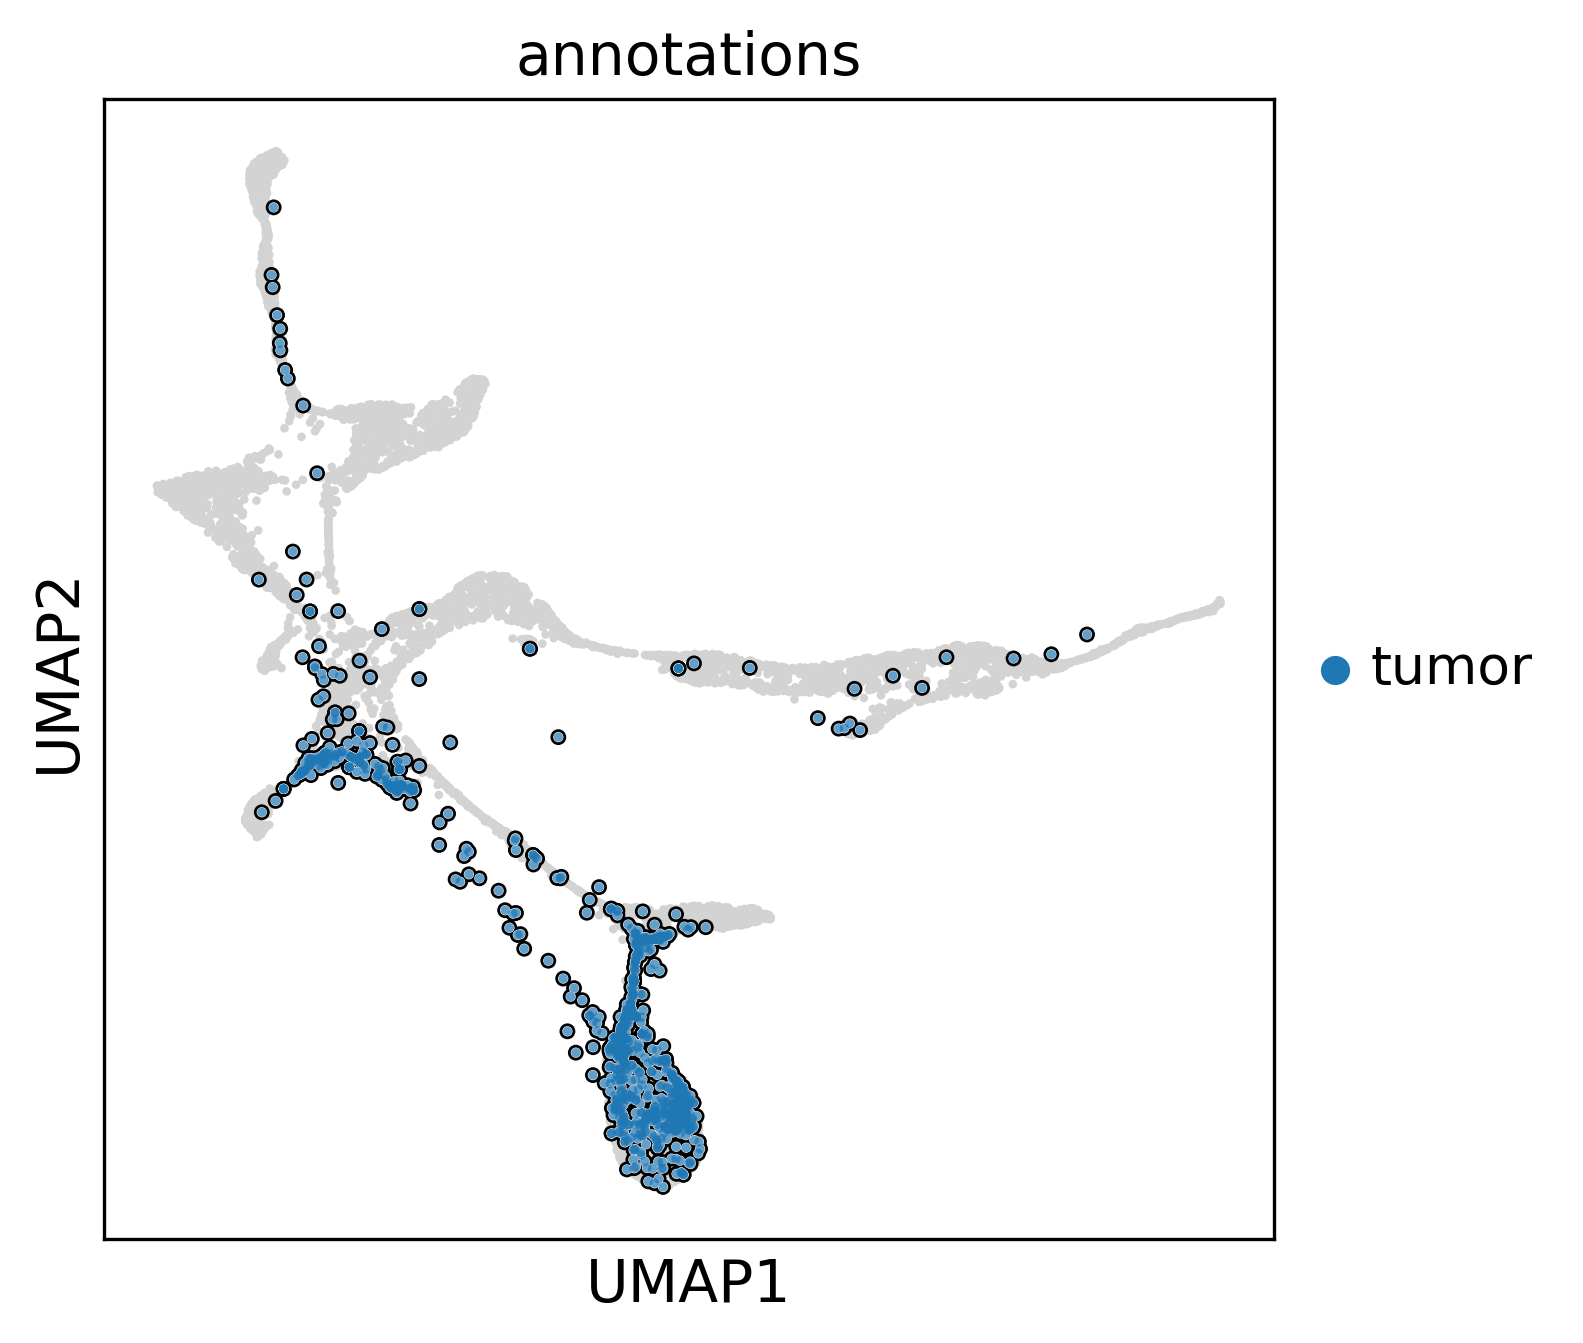

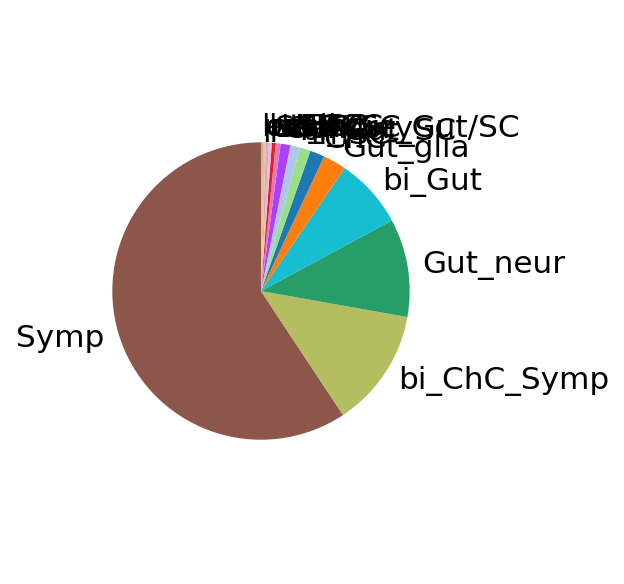

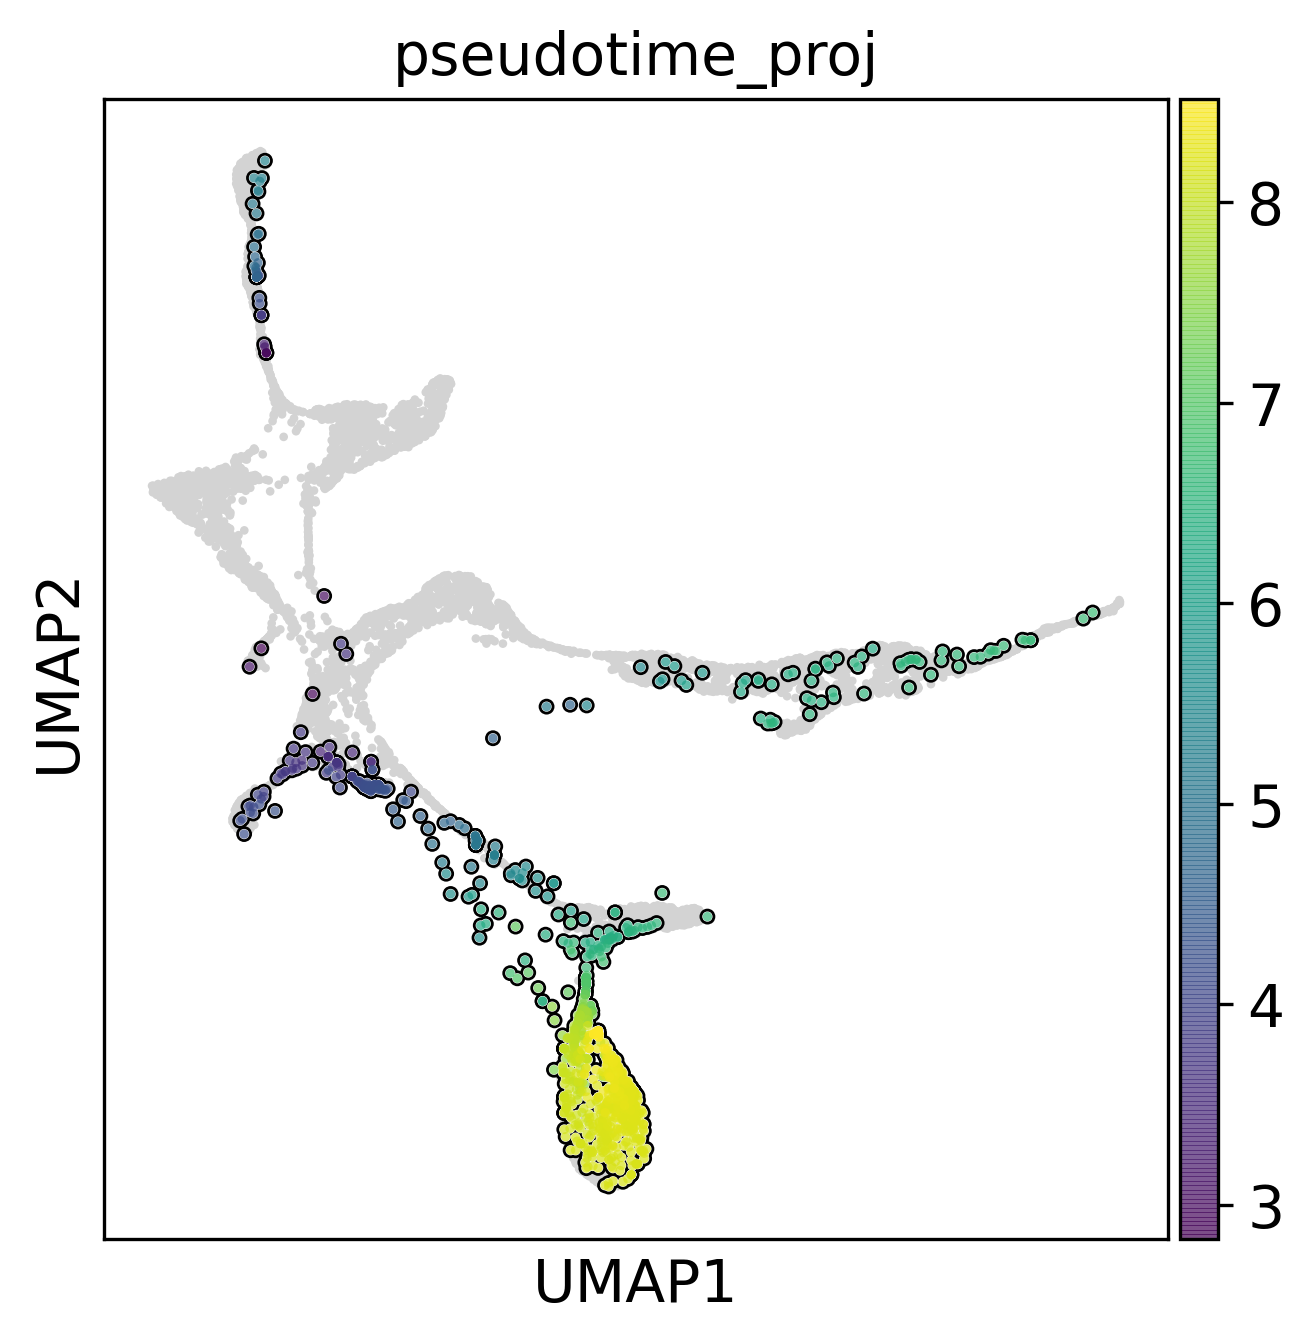

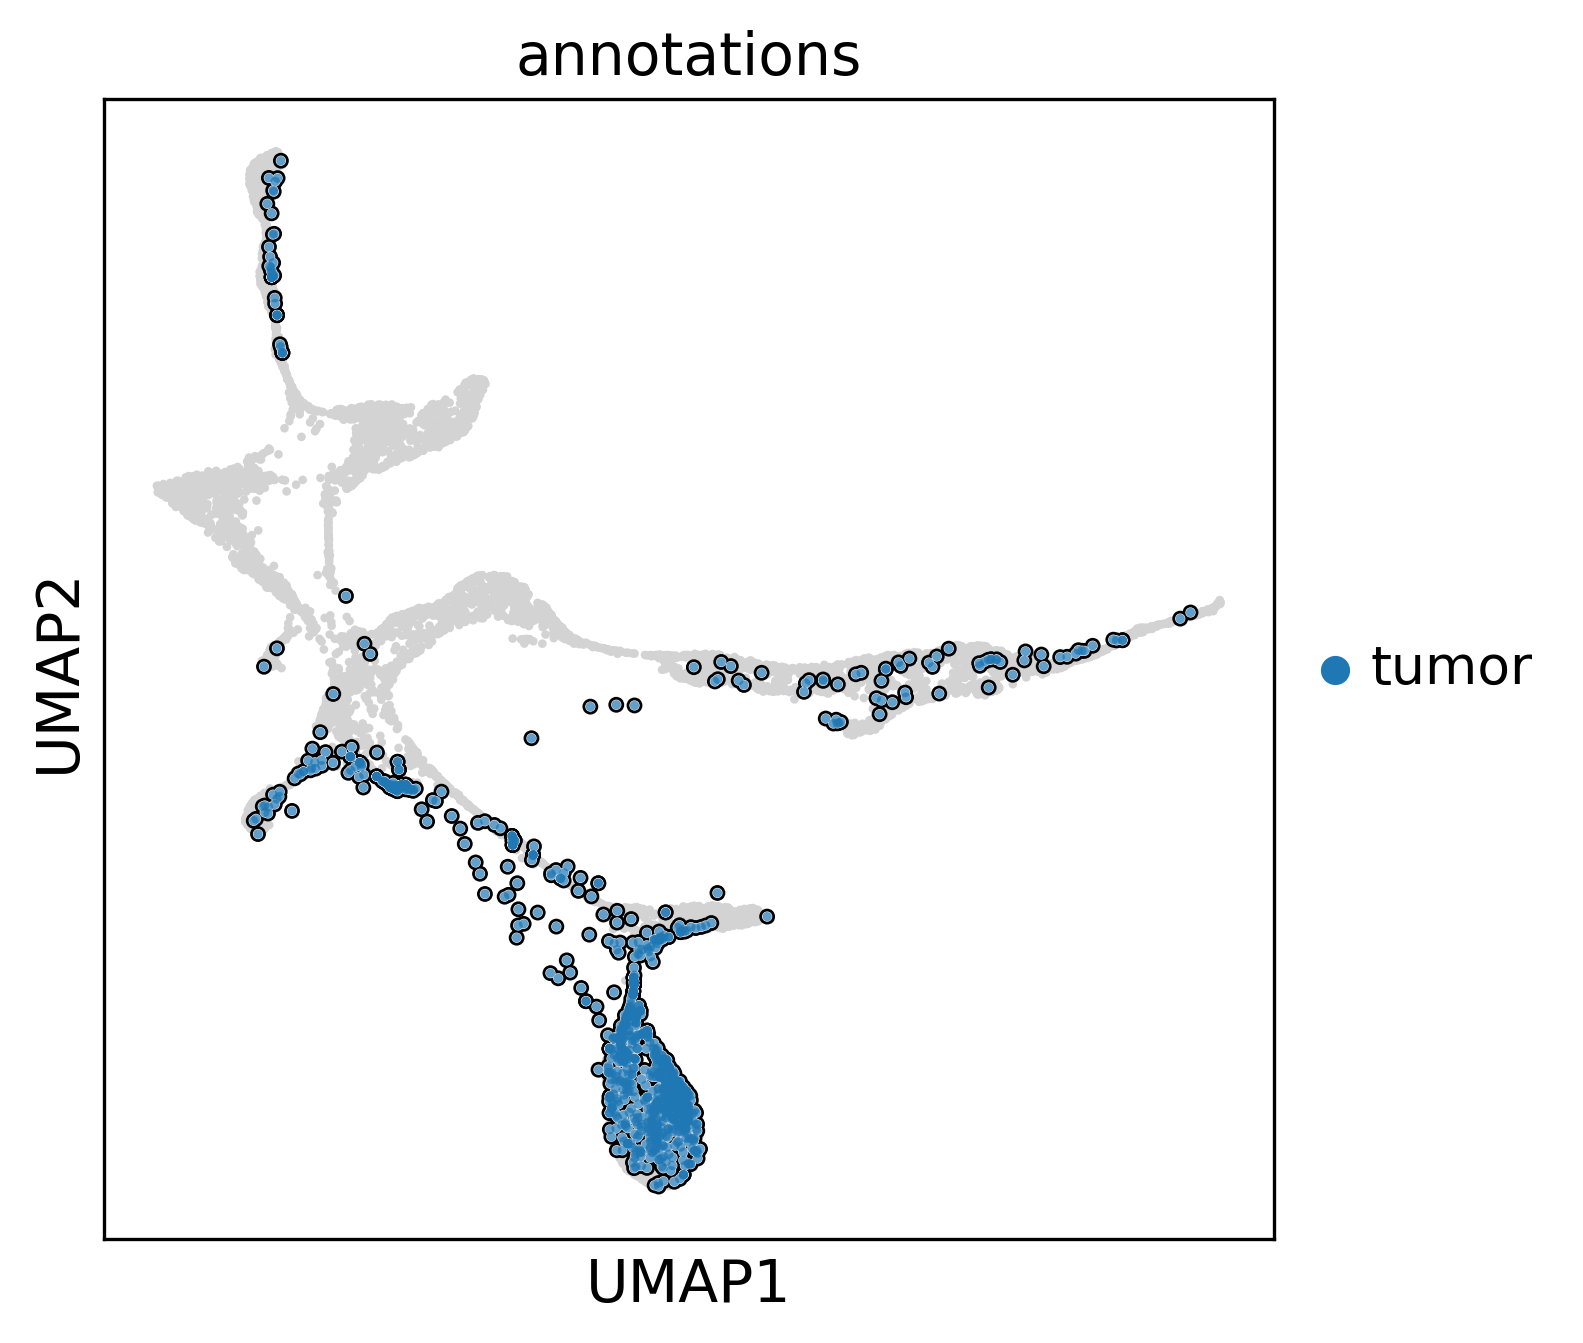

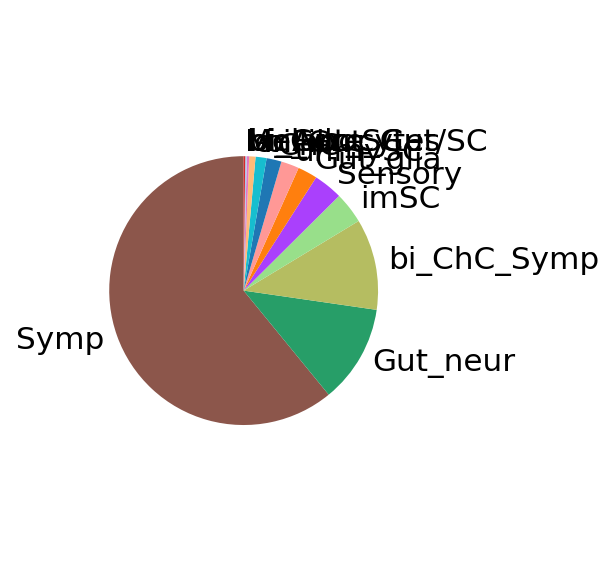

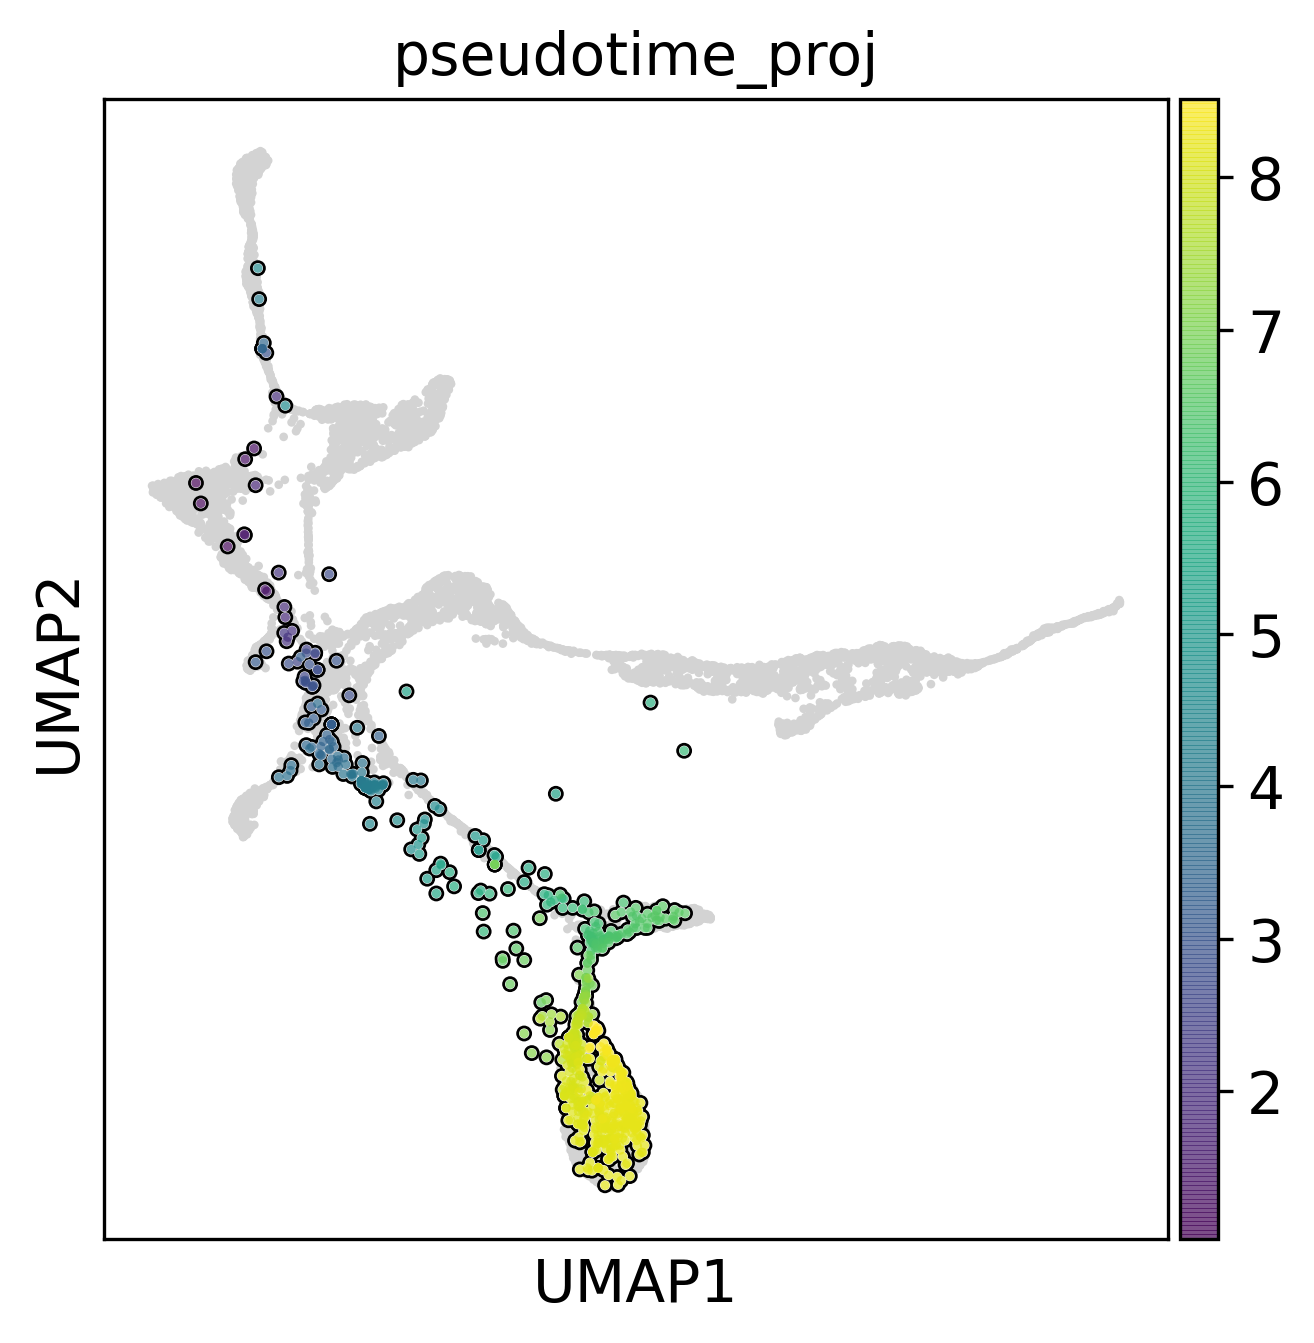

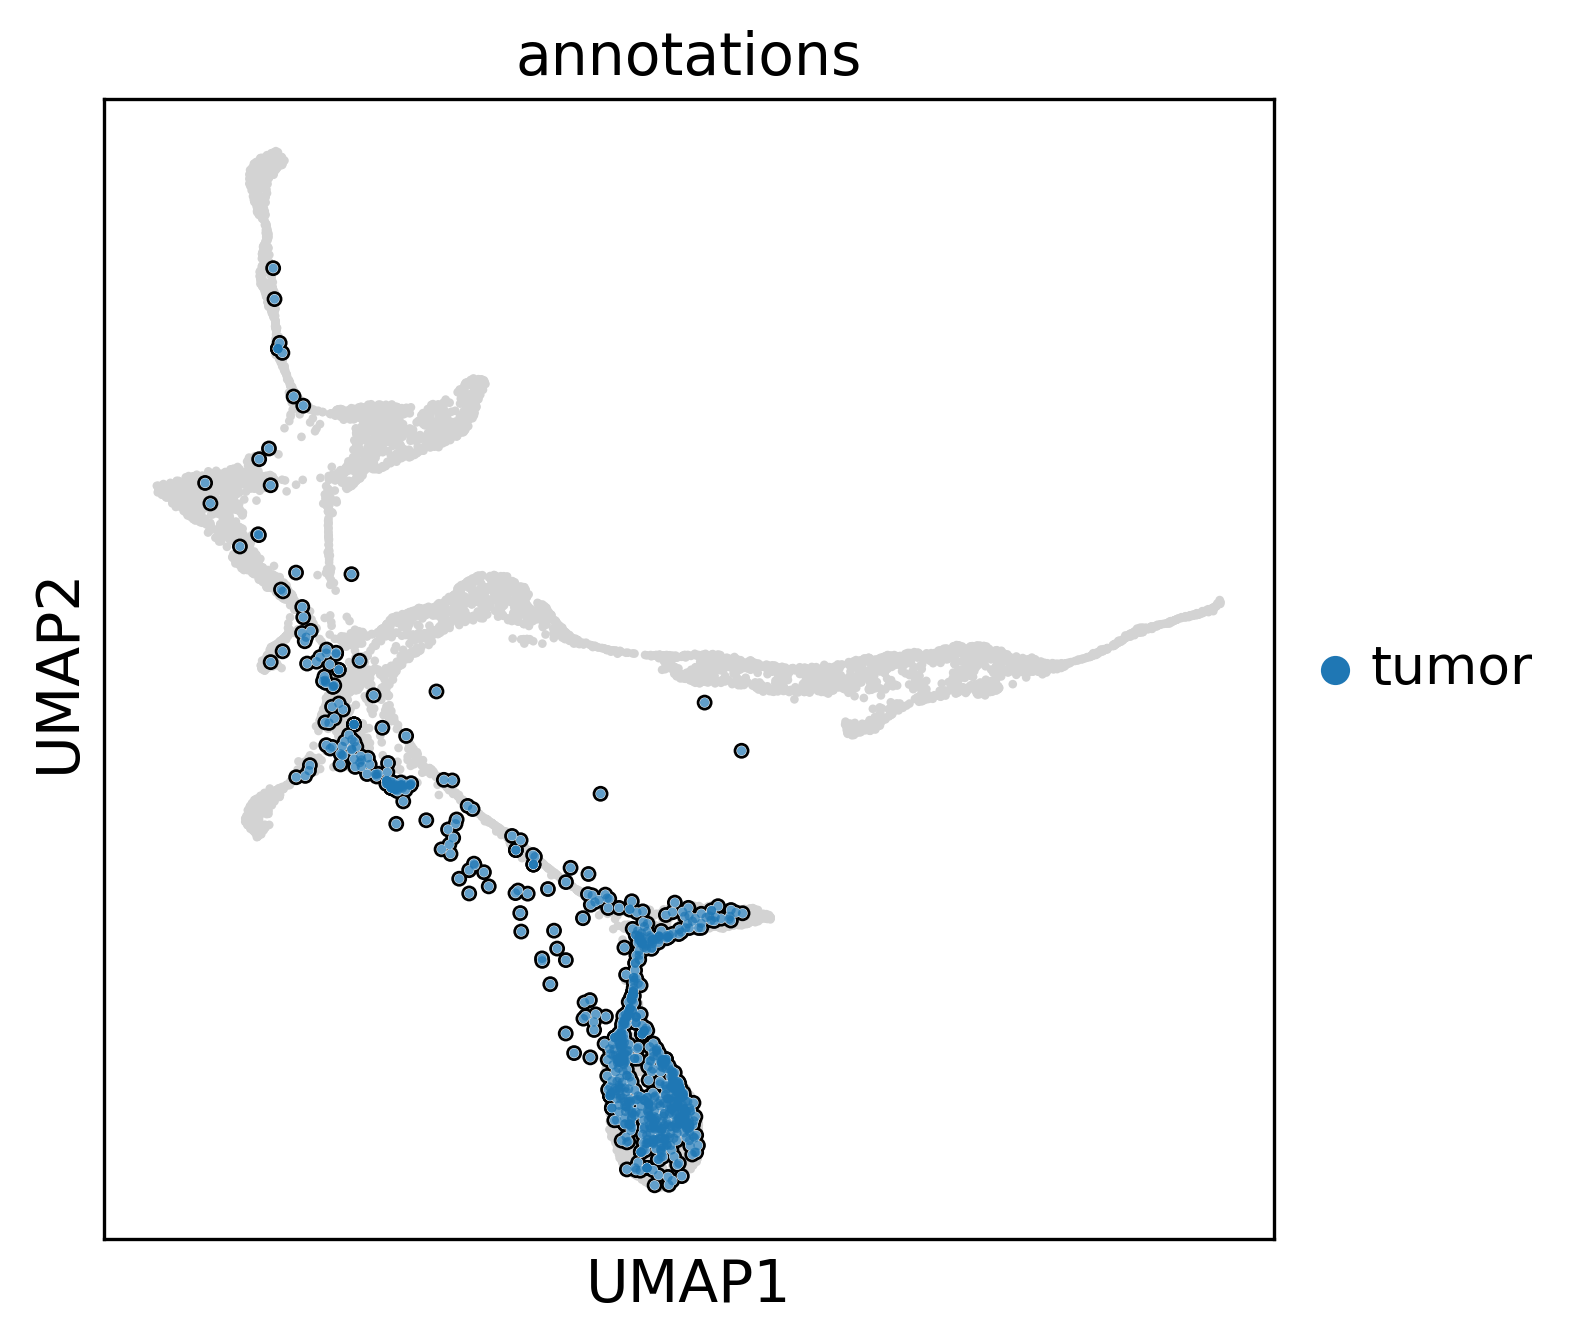

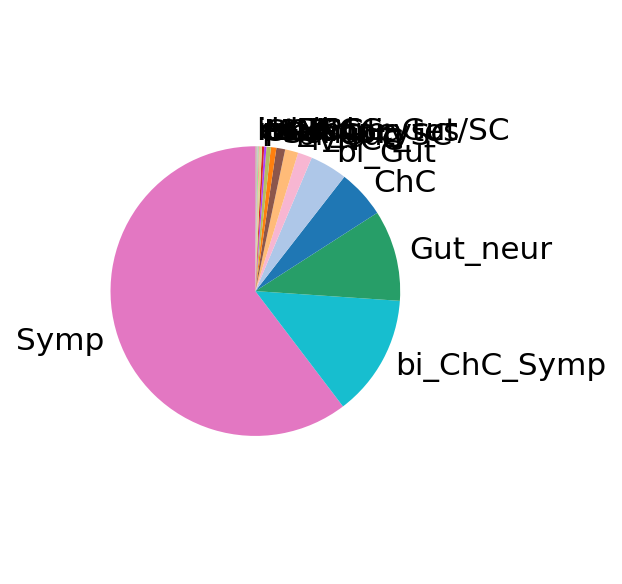

In [46]:
for s in samples[5:]:

    members = pd.Series(pd.read_table("to_align/"+s+"_members.tsv",header=None)[0].values)
    graph_conn = csr_matrix(scipy.io.mmread("to_align/"+s+"_con_graph.mtx"))
    ss2_members=members[members.str.contains("SS2")]
    tenx_members=members[~members.str.contains("SS2")]
    graph_conn=graph_conn[tenx_members.index,:][:,ss2_members.index]
    ss2_members.reset_index(drop=True,inplace=True)
    tenx_members.reset_index(drop=True,inplace=True)


    adata_sub=adata[tenx_members]
    pseudotime=adata_ss2[ss2_members].obs.t.values
    adata_sub.obs["pseudotime_proj"]=list(map(lambda i: np.nansum((graph_conn[i,:].A*pseudotime)[0]/np.sum(graph_conn[i,:].A[0])),range(graph_conn.shape[0])))
    umap=np.asarray(adata_ss2[ss2_members].obsm["X_umap"])
    adata_sub.obsm["X_umap"]=np.array(list(map(lambda i: [np.nansum((graph_conn[i,:].A*umap[:,0])[0]/np.sum(graph_conn[i,:].A[0])),
                                  np.nansum((graph_conn[i,:].A*umap[:,1])[0]/np.sum(graph_conn[i,:].A[0]))],
                       range(graph_conn.shape[0]))))

    adata_sub.obs["annotations"]=annot.loc[adata_sub.obs_names,"annotation"].values


    df=pd.concat([pd.read_table("to_align/"+s+"_milestones_proj.tsv",header=None),
               pd.read_table("to_align/"+s+"_leiden_proj.tsv",header=None),
               pd.read_table("to_align/"+s+"_proj_names.tsv",header=None)],
              axis=1)
    df.columns=["milestones_proj","ledien_proj","bc"]
    df.set_index("bc",inplace=True)
    adata_sub.obs[["milestones_proj","leiden_proj"]]=df.loc[adata_sub.obs_names,:].values
    adata_sub = adata_sub[np.abs(adata_sub.obsm["X_umap"]).sum(axis=1)>0.0001]
    sc.pp.filter_genes(adata_sub,min_cells=1)
    sc.pp.highly_variable_genes(adata_sub,flavor="cell_ranger")
    sc.pp.pca(adata_sub,use_highly_variable=True)
    sc.pp.neighbors(adata_sub)

    #sc.tl.leiden(adata_sub)
    adata_sub.obsm["X_tsne"]=sc.tl.umap(adata_sub,copy=True).obsm["X_umap"]
    

    adata_velo=scv.read(dct_smp[s]+"/dropest/velocyted.h5ad")
    adata_velo.obs_names=list(map(lambda bc: bc.split("-")[0]+"-"+s,adata_velo.obs_names))
    adata_velo=adata_velo[adata_sub.obs_names]
    adata_velo.obs=adata_sub.obs
    adata_velo.obsm=adata_sub.obsm
    scv.pp.filter_and_normalize(adata_velo, min_shared_counts=20, n_top_genes=2000)
    scv.pp.moments(adata_velo, n_pcs=30, n_neighbors=30)
    scv.tl.recover_dynamics(adata_velo)
    scv.tl.velocity(adata_velo,method="dynamical")
    scv.tl.velocity_graph(adata_velo)
    scv.tl.recover_latent_time(adata_velo)
    
    adata_sub.write_h5ad("adatas/"+s+"_adata.h5ad")
    adata_velo.write_h5ad("adatas/"+s+"_adata_velo.h5ad")
